# Sampling from a distribution over graphs

We will define a distribution over directed graphs, under the assumption that the vertices are known a-priori.

We'll focus on a class of distributions proposed by Mukherjee et al:

$$ P(G) \propto \exp \left( - \beta \cdot D(G, G^\prime) \right) $$

i.e., probability decreases exponentially with distance from some reference graph, $G^\prime$. 

The distance, $D$, could be any nonnegative notion of difference; but a useful default is Hamming distance between the graphs' edge sets.

In [1]:
include("DiGraph.jl")
include("NonGenerative.jl")
using Gen
using .DiGraphs
using .NonGenerative
using PyPlot

## Define a density over graphs

In [2]:
# in Gen, distributions are defined as singleton types:
struct GraphPriorDist <: Distribution{DiGraph} end
const graphpriordist = GraphPriorDist()

GraphPriorDist()

In [3]:
# define a hamming distance between graphs
function edge_hamming(g1::DiGraph{T}, g2::DiGraph{T}) where T
    return length(symdiff([g1.edges[i,:] for i=1:size(g1.edges)[1]],
                          [g2.edges[i,:] for i=1:size(g2.edges)[1]]))
end

# Define sampling methods for the graph distribution.
function Gen.random(gpd::GraphPriorDist, reference_graph::DiGraph{T}, beta::Number, distance_func::Function) where T
    return reference_graph
end

# if distance isn't specified, use hamming distance
function Gen.random(gpd::GraphPriorDist, reference_graph::DiGraph{T}, beta::Number) where T
    return Gen.random(gpd, reference_graph, beta, edge_hamming)
end

graphpriordist(reference_graph::DiGraph{T}, beta::Number) where T = Gen.random(graphpriordist, reference_graph, beta)

# Define a log-probability for this distribution.
function Gen.logpdf(gpd::GraphPriorDist, dg::DiGraph{T}, reference_graph::DiGraph{T}, beta::Number, distance_func::Function) where T
    return exp( -beta * distance_func(dg, reference_graph) )
end

# Again: use hamming distance by default
function Gen.logpdf(gpd::GraphPriorDist, dg::DiGraph{T}, reference_graph::DiGraph{T}, beta::Number) where T
    return Gen.logpdf(gpd, dg, reference_graph, beta, edge_hamming)
end


There are some issues with our construction:
1. This distribution is _unnormalized_. 
2. This distribution is _not generative_. It doesn't prescribe a sampling method.


However, our implementation should allow Gen's Metropolis-Hastings sampler to 'play nicely' with this distribution.
1. The distribution is unnormalized -- this means that the `logpdf` will not return correct values. However, the thing that _really_ matters in MH sampling is **change** in log-probability. And our logpdf implementation will correctly compute those.
2. The distribution isn't generative, but MH won't require us to explicitly sample from the distribution -- the whole point of MH is that it will allow us to sample from (unnormalized) log densities that have no generative description. As long as we provide a proposal distribution, we'll be fine.

### Example reference graph

We'll build an actual reference graph here, for illustrative purposes.

In [4]:
# Define a simple node type
struct Node
    name::String
    x::Float64
    y::Float64
end

In [5]:
# Define a mapping between string labels and nodes
vertex_dict = Dict("animal" => Node("animal", 0., 0.),
"mammal" => Node("mammal", -4., -1.),
"dog" => Node("dog", -5., -2.),
"cat" => Node("cat", -4., -2.),
"calico" => Node("calico", -4., -3.), 
"fish" => Node("fish", -1., -1.),
"bird" => Node("bird", 1., -1.),
"reptile" => Node("reptile", 3.0, -1.0),
"crocodile" => Node("crocodile", 4.0, -2.0),
"snake" => Node("snake", 2.0, -2.0),
"shark" => Node("shark", -2.0, -2.0),
"piranha" => Node("piranha", -0.0, -2.0)
);

In [6]:
example_tree = DiGraph(["mammal" "animal";
        "cat" "mammal";
        "calico" "cat";
        "dog" "mammal";
        "fish" "animal";
        "shark" "fish";
        "piranha" "fish";
        "bird" "animal";
        "reptile" "animal";
        "crocodile" "reptile";
        "snake" "reptile"])

DiGraph{String}(Set(["calico", "fish", "snake", "mammal", "dog", "reptile", "shark", "animal", "cat", "crocodile", "bird", "piranha"]), ["mammal" "animal"; "cat" "mammal"; … ; "crocodile" "reptile"; "snake" "reptile"])

### Some visualization machinery

We'll write some functions for visualizing graphs.

In [7]:
function visualize_vertices(digraph::DiGraph{T}, vertex_dict::Dict{T,Node}) where T
    xyn = [[vertex_dict[v].x vertex_dict[v].y vertex_dict[v].name] for v in digraph.vertices]
    xyn = vcat(xyn...,)
    scatter(xyn[:,1], xyn[:,2], s=120)
    for i=1:size(xyn)[1]
        annotate(xyn[i,3], (xyn[i,1], xyn[i,2]))
    end
end


function visualize_edges(digraph::DiGraph{T}, vertex_dict::Dict{T,Node}) where T
    for i=1:size(digraph.edges)[1]
        xs = [vertex_dict[digraph.edges[i,1]].x; vertex_dict[digraph.edges[i,2]].x]
        ys = [vertex_dict[digraph.edges[i,1]].y; vertex_dict[digraph.edges[i,2]].y]
        dx = xs[2] - xs[1]
        dy = ys[2] - ys[1]
        arrow(xs[1], ys[1], dx, dy, color="k", zorder=0, head_length=0.25, length_includes_head=true,
              head_width=0.125)
    end
end


function visualize_weighted_edges(vertex_dict::Dict{T,Node}, 
                                  weight_dict::Dict{T,Dict{T,Float64}}) where T
    for (orig, subdict) in pairs(weight_dict)
        for (dest, w) in pairs(subdict)
            xs = [vertex_dict[digraph.edges[i,1]].x; vertex_dict[digraph.edges[i,2]].x]
            ys = [vertex_dict[digraph.edges[i,1]].y; vertex_dict[digraph.edges[i,2]].y]
            dx = xs[2] - xs[1]
            dy = ys[2] - ys[1]
            arrow(xs[1], ys[1], dx, dy, color="k", zorder=0, head_length=0.25, length_includes_head=true,
                  head_width=0.125)
        end
    end
end


function visualize_digraph(digraph::DiGraph{T}, vertex_dict::Dict{T, Node}) where T 
    visualize_vertices(digraph, vertex_dict)
    visualize_edges(digraph, vertex_dict)
end


function visualize_weighted_digraph(digraph::DiGraph{T}, vertex_dict::Dict{T, Node},
                                    weight_dict::Dict{T,Dict{T,Float64}}) where T
    visualize_vertices(digraph, vertex_dict)
    visualize_weighted_edges(vertex_dict, weight_dict)
end

visualize_weighted_digraph (generic function with 1 method)

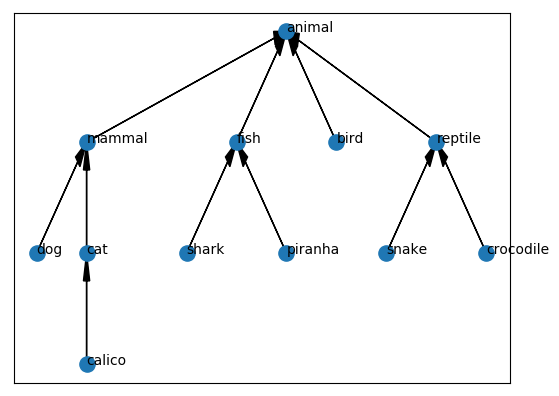

In [8]:
visualize_digraph(example_tree, vertex_dict)
xticks([])
yticks([])
show()

## Write a probabilistic program

Practically a one-liner. All it does is draw samples from our distribution -- there's no posterior inference going on here.

In [9]:
@gen function graph_generator(reference_graph::DiGraph{String}, beta::Float64)
    g = @trace(graphpriordist(reference_graph, beta), :graph)
    return g
end;

In order to sample from this, we'll need to define a proposal distribution that explores a space of directed graphs.

## A graph proposal distribution

As a first pass, we'll define operations that allow us to explore the space of directed graphs in a mostly unconstrained fashion. 
That is, we won't enforce most graph properties: connectedness, acyclicity, in-degree, etc.
However, we *will* enforce a couple of constraints (mostly for aesthetic reasons): no 1- or 2-cycles.

In [181]:
struct DagProposal <: NonGenProposal{DiGraph} end
dagproposal = DagProposal()

function random(dagproposal::DagProposal, address::Symbol, current_trace, delete_prob::Float64=0.66,
                expected_degree::Float64=3.0)
    
    # Get the current DiGraph
    dg = copy(current_trace[address])
    lp = 0.0
    
    # Get a random vertex
    v = rand(collect(dg.vertices))
    V = length(dg.vertices)
    lp += log(1.0/V)
    
    inneighb = in_neighbors(dg, v)
    neighbors = collect(union(inneighb, out_neighbors(dg, v)))
    N = length(neighbors)
    
    # Choose whether to add a new edge
    t = log(0.5) / log(1.0 - expected_degree/V)
    add_prob = (1.0 - N/V)^t
    to_add = bernoulli(add_prob)
    
    if to_add
        lp += log(add_prob)
        # Select a non-neighbor at random; add an edge *to* it
        non_neighbors = setdiff(dg.vertices, neighbors)
        n_n = rand(collect(non_neighbors))
        lp += log(1.0 / length(non_neighbors))    
        add_edge!(dg, v, n_n)
    
    else
        lp += log(1.0 - add_prob)
        # select a neighbor at random; remove or reverse that edge.
        n = rand(neighbors)
        lp += log(1.0 / N)
        is_in = in(n, inneighb)
        if is_in
            lp += log(1.0*length(inneighb)/N)
            remove_edge!(dg, n, v)
            add_edge!(dg, v, n)
        else
            lp += log(1.0 - 1.0*length(inneighb)/N)
            remove_edge!(dg, v, n)
            if bernoulli(delete_prob)
                lp += log(delete_prob)
            else
                add_edge!(dg, n, v)
                lp += log(1.0 - delete_prob)
            end
        end
        
    end
    
    # Store & return the new DiGraph
    new_choices = Gen.choicemap()
    new_choices[address] = dg
    
    return new_choices, lp
        
end


function logpdf(dagprop::DagProposal, address::Symbol, new_trace, cur_trace, delete_prob::Float64=0.66,
                expected_degree::Float64=3.0)
    
    new_dag = new_trace[address]
    cur_dag = cur_trace[address]
    V = length(cur_dag.vertices)
    t = log(0.5) / log(1.0 - expected_degree/V)
    
    new_edges = Set([new_dag.edges[i,:] for i=1:size(new_dag.edges)[1]])
    cur_edges = Set([cur_dag.edges[i,:] for i=1:size(cur_dag.edges)[1]])
    
    new_exc = setdiff(new_edges, cur_edges)
    cur_exc = setdiff(cur_edges, new_edges)
    println("NEW EXCLUSIVE: ", new_exc)
    println("OLD EXCLUSIVE: ", cur_exc)
    
    if length(new_exc) == 1 && length(cur_exc) == 0     # an edge was *added*
        v = first(new_exc)[1]
        N = length(union(in_neighbors(cur_dag, v), out_neighbors(cur_dag, v)))
        add_prob = (1.0 - N/V)^t
        return log(1.0/V * add_prob * 1.0/(V - N))
    elseif length(cur_exc) == 1 
        v = first(cur_exc)[1]
        N = length(union(in_neighbors(cur_dag, v), out_neighbors(cur_dag, v)))
        not_add_prob = 1.0 - (1.0 - N/V)^t
        if length(new_exc) == 0        # an edge was *removed*
            return log(1.0/V * not_add_prob * delete_prob * 1.0/N)
        elseif length(new_exc) == 1    # an edge was *reversed*
            return log(1.0/V * not_add_prob * (1.0 - delete_prob) * 1.0/N )
        end
    else
        return -Inf64
    end
end

logpdf (generic function with 3 methods)

In [182]:
beta = 0.1
tr, _ = Gen.generate(graph_generator, (example_tree, beta))
println("original graph has ", size(tr[:graph].edges)[1], " edges")

original graph has 11 edges


In [198]:
cmap, lp = random(dagproposal, :graph, tr)
println("proposed graph has ", size(cmap[:graph].edges)[1], " edges")
println("log P(proposed | current) = ", lp)

proposed graph has 11 edges
log P(proposed | current) = -4.276666119016055


In [199]:
newtr, lp, _, _, = Gen.update(tr, (example_tree, beta), (), cmap)
println("update log odds: ", lp)

update log odds: -0.18126924692201818


In [200]:
logpdf(dagproposal, :graph, newtr, tr)

NEW EXCLUSIVE: Set(Array{String,1}[["reptile", "crocodile"]])
OLD EXCLUSIVE: Set(Array{String,1}[["crocodile", "reptile"]])


-5.229039161574756

In [194]:
logpdf(dagproposal, :graph, tr, newtr)

NEW EXCLUSIVE: Set(Array{String,1}[])
OLD EXCLUSIVE: Set(Array{String,1}[["calico", "snake"]])


-4.6277831657267114